<a href="https://colab.research.google.com/github/PsorTheDoctor/Sekcja-SI/blob/master/modern_approach/one_shot_learning/siamese_network_with_contrastive_loss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Syjamska sieć neuronowa ze stratą kontrastową
##Import bibliotek

In [8]:
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

##Hiperparametry

In [9]:
epochs = 10
batch_size = 16
margin = 1  # Margines straty kontrastowej

##Załadowanie zbioru MNIST

In [10]:
(x_train_val, y_train_val), (x_test, y_test) = keras.datasets.mnist.load_data()

# Zmiana typu danych na liczby zmiennoprzecinkowe
x_train_val = x_train_val.astype('float32')
x_test = x_test.astype('float32')

##Deklaracja zbioru treningowego i walidacyjnego

In [11]:
x_train, x_val = x_train_val[:30000], x_train_val[30000:]
y_train, y_val = y_train_val[:30000], y_train_val[30000:]
del x_train_val, y_train_val

##Stworzenie par obrazów

In [21]:
def make_pairs(x, y):
  num_classes = max(y) + 1
  digit_indices = [np.where(y == i)[0] for i in range(num_classes)]

  pairs = []
  labels = []

  for idx1 in range(len(x)):
    x1 = x[idx1]
    label1 = y[idx1]
    idx2 = random.choice(digit_indices[label1])
    x2 = x[idx2]

    pairs += [[x1, x2]]
    labels += [1]

    label2 = random.randint(0, num_classes - 1)
    while label2 == label1:
      label2 = random.randint(0, num_classes - 1)

    idx2 = random.choice(digit_indices[label2])
    x2 = x[idx2]

    pairs += [[x1, x2]]
    labels += [0]
  
  return np.array(pairs), np.array(labels).astype('float32')

# stworzenie par treningowych
pairs_train, labels_train = make_pairs(x_train, y_train)

# stworzenie par walidacyjnych
pairs_val, labels_val = make_pairs(x_val, y_val)

# stworzenie par testowych
pairs_test, labels_test = make_pairs(x_test, y_test)

In [22]:
x_train_1 = pairs_train[:, 0]  # x_train_1.shape is (60000, 28, 28)
x_train_2 = pairs_train[:, 1]

x_val_1 = pairs_val[:, 0]  # x_val_1.shape is (60000, 28, 28)
x_val_2 = pairs_val[:, 1]

x_test_1 = pairs_test[:, 0]  # x_test_1.shape is (20000, 28, 28)
x_test_2 = pairs_test[:, 1]

##Wizualizacja par i ich etykiet

In [23]:
def visualize(pairs, labels, to_show=6, num_col=3, predictions=None, test=False):

  num_row = to_show // num_col if to_show // num_col != 0 else 1

  to_show = num_row * num_col

  fig, axes = plt.subplots(num_row, num_col, figsize=(5, 5))
  for i in range(to_show):

    if num_row == 1:
      ax = axes[i % num_col]
    else:
      ax = axes[i // num_col, i % num_col]
    
    ax.imshow(tf.concat([pairs[i][0], pairs[i][1]], axis=1), cmap='gray')
    ax.set_axis_off()
    if test:
      ax.set_title('True: {} | pred: {:.5f}'.format(labels[i], predictions[i][0]))
    else:
      ax.set_title('Label: {}'.format(labels[i]))
  if test:
    plt.tight_layout(rect=(0, 0, 1.9, 1.9), w_pad=0.0)
  else:
    plt.tight_layout(rect=(0, 0, 1.5, 1.5))
  plt.show()

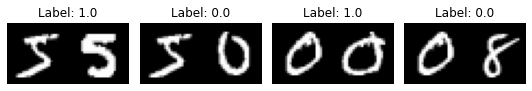

In [24]:
visualize(pairs_train[:-1], labels_train[:-1], to_show=4, num_col=4)

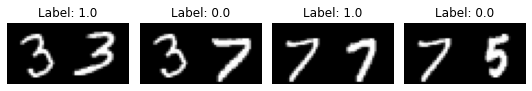

In [25]:
visualize(pairs_val[:-1], labels_val[:-1], to_show=4, num_col=4)

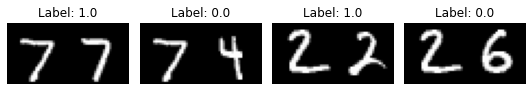

In [26]:
visualize(pairs_test[:-1], labels_test[:-1], to_show=4, num_col=4)

##Deklaracja modelu

In [27]:
def euclidean_distance(vects):
  x, y = vects
  sum_square = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
  return tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon()))

input =layers.Input((28, 28, 1))
x = tf.keras.layers.BatchNormalization()(input)
x = layers.Conv2D(4, (5, 5), activation='tanh')(x)
x = layers.AveragePooling2D(pool_size=(2, 2))(x)
x = layers.Conv2D(16, (5, 5), activation='tanh')(x)
x = layers.AveragePooling2D(pool_size=(2, 2))(x)
x = layers.Flatten()(x)

x = tf.keras.layers.BatchNormalization()(x)
x = layers.Dense(10, activation='tanh')(x)
embedding_net = keras.Model(input, x)

input_1 = layers.Input((28, 28, 1))
input_2 = layers.Input((28, 28, 1))

# Sieć syjamska dzieli wagi między sieci siostrzane.
# Aby to umożliwić ustawimy ten sam embedding dla obu sieci siostrzanych.
tower_1 = embedding_net(input_1)
tower_2 = embedding_net(input_2)

merge_layer = layers.Lambda(euclidean_distance)([tower_1, tower_2])
normal_layer = tf.keras.layers.BatchNormalization()(merge_layer)
output_layer = layers.Dense(1, activation='sigmoid')(normal_layer)
siamese = keras.Model(inputs=[input_1, input_2], outputs=output_layer)

##Deklaracja straty kontrastowej

In [34]:
def loss(margin=1):

  def contrastive_loss(y_true, y_pred):

    square_pred = tf.math.square(y_pred)
    margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
    return tf.math.reduce_mean(
        (1 - y_true) * square_pred + (y_true) * margin_square
    )
  return contrastive_loss

##Kompilacja modelu ze stratą kontrastową

In [35]:
siamese.compile(loss=loss(margin), optimizer='RMSProp', metrics=['accuracy'])
siamese.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
model (Functional)              (None, 10)           5318        input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1)            0           model[0][0]                

##Trening modelu

In [36]:
history = siamese.fit(
    [x_train_1, x_train_2],
    labels_train,
    validation_data=([x_val_1, x_val_2], labels_val),
    batch_size=batch_size,
    epochs=epochs
)

Epoch 1/10
3750/3750 [==============================] - 25s 6ms/step - loss: 0.5000 - accuracy: 0.5000 - val_loss: 0.5000 - val_accuracy: 0.5000
Epoch 2/10
3750/3750 [==============================] - 23s 6ms/step - loss: 0.5000 - accuracy: 0.5000 - val_loss: 0.5000 - val_accuracy: 0.5000
Epoch 3/10
3750/3750 [==============================] - 23s 6ms/step - loss: 0.5000 - accuracy: 0.5000 - val_loss: 0.5000 - val_accuracy: 0.5000
Epoch 4/10
3750/3750 [==============================] - 23s 6ms/step - loss: 0.5000 - accuracy: 0.5000 - val_loss: 0.5000 - val_accuracy: 0.5000
Epoch 5/10
3750/3750 [==============================] - 23s 6ms/step - loss: 0.5000 - accuracy: 0.5000 - val_loss: 0.5000 - val_accuracy: 0.5000
Epoch 6/10
3750/3750 [==============================] - 23s 6ms/step - loss: 0.5000 - accuracy: 0.5000 - val_loss: 0.5000 - val_accuracy: 0.5000
Epoch 7/10
3750/3750 [==============================] - 24s 6ms/step - loss: 0.5000 - accuracy: 0.5000 - val_loss: 0.5000 - val_ac

##Wizualizacja wyników

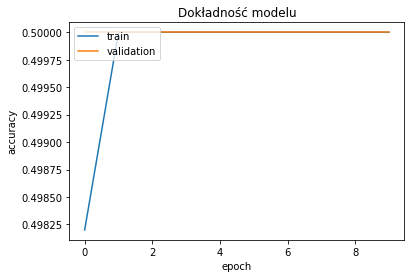

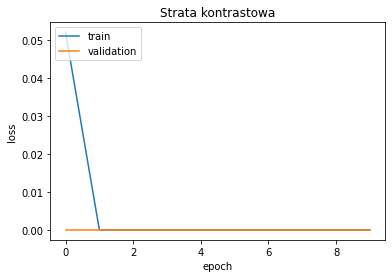

In [31]:
def plt_metric(history, metric, title, has_valid=True):

  plt.plot(history[metric])
  if has_valid:
    plt.plot(history['val_' + metric])
    plt.legend(['train', 'validation'], loc='upper left')
  plt.title(title)
  plt.ylabel(metric)
  plt.xlabel('epoch')
  plt.show()

plt_metric(history=history.history, metric='accuracy', title='Dokładność modelu')
plt_metric(history=history.history, metric='loss', title='Strata kontrastowa')

In [32]:
results = siamese.evaluate([x_test_1, x_test_2], labels_test)
print('test loss, test acc:', results)

625/625 [==============================] - 2s 3ms/step - loss: 7.7307e-11 - accuracy: 0.5000
test loss, test acc: [7.73070565895928e-11, 0.5]


##Wizualizacja predykcji

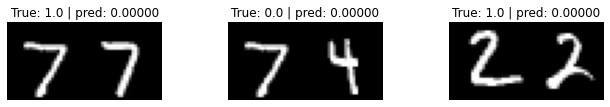

In [33]:
preds = siamese.predict([x_test_1, x_test_2])
visualize(pairs_test, labels_test, to_show=3, predictions=preds, test=True)